# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# We will use CIFAR-10 as our in-distribution dataset.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
batch_size = 32
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)

ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

# In case we want to pretty-print classifications.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Pretrained model, otherwise write a train epoch function
#model = CNN().to(device) cuda
#model.load_state_dict(torch.load('./cifar10_CNN.pth')) cuda
model = CNN()
model.load_state_dict(torch.load('./cifar10_CNN.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

tensor(0.6029)


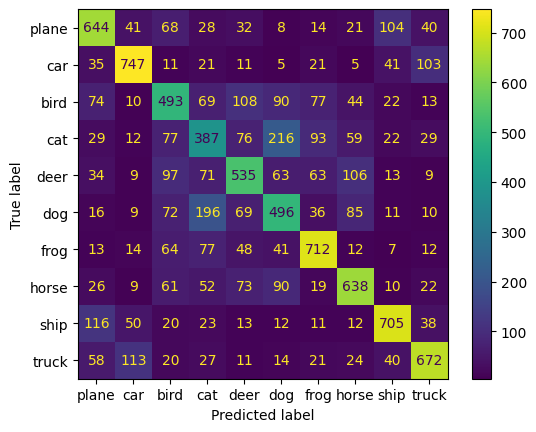

In [5]:
#Test model
model.eval()
y_gt, y_pred = [], []
for it, data in  enumerate(dl_test):
    x, y = data
    x, y = x.to(device), y.to(device)
    
    yp = model(x)
    y_pred.append(yp.argmax(1))
    y_gt.append(y)

#print(y_pred.shape)

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_pred_t)
print(accuracy)

from sklearn import metrics
cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

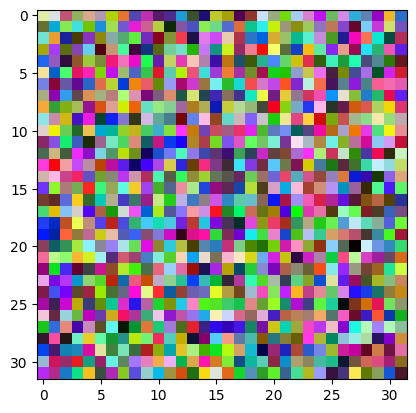

In [6]:
# Fake dataset.
ds_fake = FakeData(size=1000, image_size=(3, 32, 32), transform=transform) #ogni canale è campionato da una gaussiana
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=batch_size, shuffle=False, num_workers=2)

# Plot a fake image.
plt.imshow(FakeData(size=1, image_size=(3, 32, 32))[0][0])

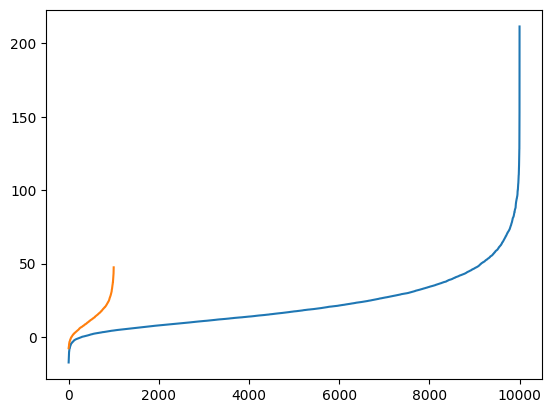

In [7]:
def max_logit(logits):
    s = logits.max(dim=1)[0]
    return s

def max_softmax(logits, T=1.0):
    s = F.softmax(logits/T, 1)
    s = s.max(dim=1)[0]
    return s


def compute_scores(model, data_loader, score_fun):
    scores=[]

    for data in data_loader:
        x, y = data
        x, y = x.to(device), y.to(device)
        output = model(x)
        s = score_fun(output)
        scores.append(s)
    
    scores_t = torch.cat(scores)
    return scores_t

scores_test = compute_scores(model, dl_test, max_logit)
scores_fake = compute_scores(model, dl_fake, max_logit)
plt.plot(sorted(scores_test.detach().cpu()))
plt.plot(sorted(scores_fake.detach().cpu()))

In [8]:
# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for (Xs, _) in dl:
            logits.append(model(Xs.to(device)).cpu().numpy())
    return np.vstack(logits)

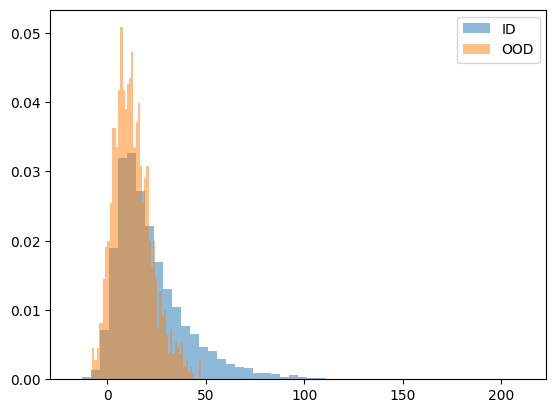

In [9]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_fake)

# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


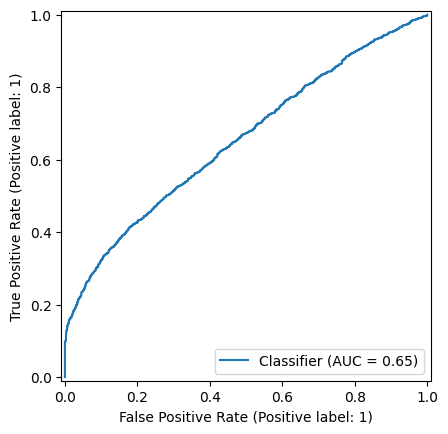

In [16]:
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))
metrics.RocCurveDisplay.from_predictions(y.detach().cpu(), ypred.detach().cpu())


---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [18]:
# prendi modello, fai forward, prendi gradiente (dalla x) e calcola il segno
# ricordarsi di mettere requires_grad=True all'esempio
# segno scalato di un epsilon

# es generare un adversarial sample per ogni esempio
# provare prima ciclo di training e poi ciclo di adversarial training

import torchvision

class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450867..1.0000001].


7 7


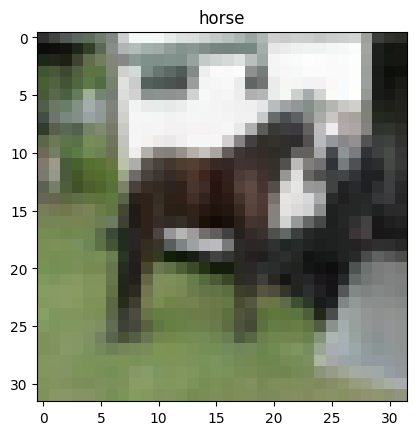

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.028294094..1.007].


Attack!!
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
5 7
Success!


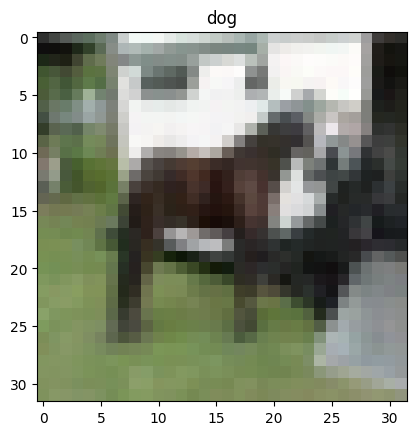

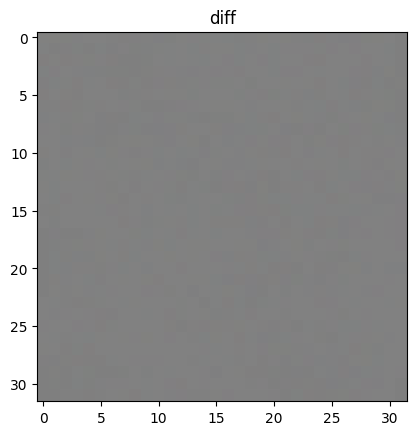

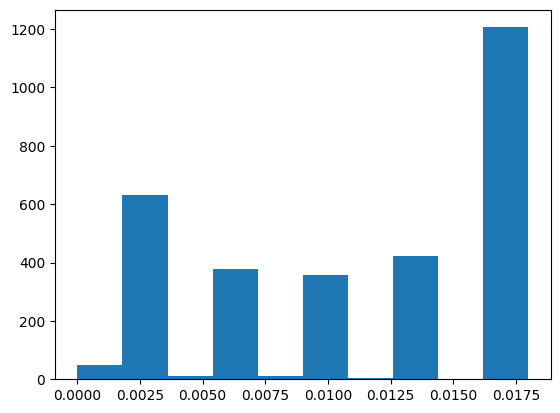

In [20]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in dl_test:
    x, y = data
    break

sample_id = 20
x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)
    
before = x.clone()
output=model(x)
eps = 0.002
print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item():
    print('classifier is already wrong!')
else:
    print('Attack!!')

    #only attack if y==model(x)
    while output.argmax() == y: #attack until success!

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        l = loss(output,y)
        l.backward()



        x = x + eps*torch.sign(x.grad)#fgsm

        print(output.argmax().item(),  y.item())
        if output.argmax().item()!=  y.item():
            print('Success!')



    img = inv(x[0])
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(classes[output.argmax()])
    plt.show()

    diff = torch.abs(x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [ ]:
# Your code here.



---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


In [ ]:
#3.3 targeted adversarial attacks

